Ćwiczenie 2. Indukcja drzew decyzyjnych C5.0 (C4.5) w R


Piotr Błoński 225959

Celem ćwiczenia było zapoznanie się z indukcjądrzew decyzyjnych C5.0 na platformie R.
W tym celu wykorzystałem poniższe biblioteki:

In [13]:
options(warn=-1) #Wyłączenie warningów aby w sprawozdaniu niebyły drukowane
library(tidyverse)
library(C50) #Drzewa decyzyjne C5.0
library(caret)#Pakiet do uczenia maszynowego
library(MLmetrics)# Pakiet zawierający metryki takie jak Fscore, Precision itp.
library(rattle) #fency plot
options(repr.plot.width=8, repr.plot.height=3)

Należy zbudować model klasyfikatora na zbiorach danych: iris, wine, glass, seeds. 
Razem ze sprawozdaniem dołączone są pliki csv zawierające te zbiory.

In [14]:
iris_data = read.csv(file = "iris.csv") #załaduj do iris_data dane Iris.
head(iris_data,3) # 3 pierwsze rekordy z datasetu

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,5.1,3.5,1.4,0.2,Iris-setosa
2,2,4.9,3.0,1.4,0.2,Iris-setosa
3,3,4.7,3.2,1.3,0.2,Iris-setosa


Jak widać dane Iris posiadają kolumne z klasą - Species która nas interesuje, w R jest faktorem.
Absolutnie nie interesuje nas kolumna Id ponieważ od Id nie ma żadnego wpływu na to jakiego gatunku rośliną będzie dany Irys. Będzie trzeba w procesie uczenia pominąć tą kolumne.

In [15]:
wine_data = read.csv(file = "wine.csv") #załaduj do wine_data dane Wine Quality
head(wine_data,3)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5


In [16]:
glass_data = read.csv(file = "glass.csv") #załąduj do glass_data dane Glass
head(glass_data,3)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0,1


W danych glass i wine ostatnie kolumny niestety mają w R typ Int co powoduje błędy! Typu jak w [1]. Aby tego uniknąć w funkcji uczące będziemy przerabiać tą kolumne na factor. 

In [17]:
seed_data = read.csv(file = "seeds.csv") #załaduj do seed_data dane Seeds
head(seed_data,3)

,Area,Perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,lenght_of_kernel_groove,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
2,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
3,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1


W informacjach o danych Seeds, jest napisane że compactness jest zależne od Area i Perimeter jako:
- compactness =  $4*pi*Area/Perimeter^2$ \
Dlatego też w procesie uczenia nie będziemy korzystać z tej kolumny za pomocą poniższej lini:

In [18]:
column_to_drop <- c("compactness")
seed_data <- seed_data[ , !(names(seed_data) %in% column_to_drop)]

W trakcie wykonywania crossvalidacji za pomocą biblioteki caret okazało się że jedyne metryki jakie nam zwraca to Accuracy i Kappa. A interesują nas Fscore, Accuracy, Precision i Recall. W tym celu zgodnie z dokumentacja biblioteki caret [2], stworzyłem własną funkcje z metrką.

In [19]:
metrics <- function(data, lev = NULL, model = NULL) 
{
  f1_val <- F1_Score(y_pred = data$pred, y_true = data$obs, positive = lev[1])  
  rec_val <-Recall(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  sen_val = Sensitivity(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  pre_val = Precision(y_pred = data$pred, y_true = data$obs, positive = lev[1])
  acc_val = Accuracy(y_pred = data$pred, y_true = data$obs)  
  c(fScore = f1_val,Recall = rec_val, Sensitivity = sen_val, Precision = pre_val,Accuracy=acc_val)
}

Funkcja ta jest używana podczas caret'owego train w celu walidacji modelu. Przy użyciu caretowej crossvalidacji powinna sie wykonywać dla wszystkich foldów i zwrócić wartość średnią.Funkcja ta wykorzystuje funkcje metryki dostępne z biblioteki MLmetrics.

Funkcja odpowiedzialna za uczenie modelu naszego drzewa decyzyjnego zwraca metryki i pomiary na modelu jako dataframe. Przymuje następujące parametry:
- Param-names - jest to string który zawiera informacje jakie parametry modelu będzie posiadało nasze drzewo decyzyjne. Ten parametr używany jest tylko i wyłącznie jako nazwa identyfikacyjna pomiaru.
- dataset - np iris_data - dataframe którym będziemy uczyć. 
- model_type - 'tree' lub 'rules' - parametr przekazywany do funkcji train w celu wybrania czy drzewo ma być rule-based czy nie.
- straing_col_number - kolumna startowa którą od której chcemy zacząć podawać dane. Najczęściej 1 w przypadku gdyby jednak kolumna Id była jako pierwsza (np Iris) to można ustawić np 2. Ten parametr pojawił się tylko i wyłącznie dlatego że w trakcie pisania tego skryptu dość późno nauczyłem się dropować kolumny. 
- last_col_number - ostatnia kolumna
- formula - formuła R np 'Species ~.' przekazywana do train
- folds - ilość foldów w crossvalidacji. \
Parametry opisane pod kodem: 
- Winnowing - parametr True / False - jest odpowiedzialny za to czy powinna zostać użyta feature selection.
- Fuzzy - pamater True / False - odpowiedzialny za fuzzyThreshold. Odpowiedzialny za 'zaawansowane dzielenie danych' 
- NoPruning - parametr True / False - odpowiedzialny jest za przycinanie końcowe drzewa w celu jego uproszczenia. Nazwa parametru to w rzeczywistości noGlobablPruning więc zaznaczenia na True oznacze brak przycinania. \
Opisy tych parametrów można znaleźć w https://cran.r-project.org/web/packages/C50/C50.pdf

In [20]:
TreeModel_caret <- function(param_names,dataset,model_type,starting_col_number,last_col_number,formula,folds,winnowing,fuzzy,GlobalPruning
){
    #Selekcja danych
    test = dataset$last_col_number
    dataset[,ncol(dataset)] = as.factor(dataset[,ncol(dataset)])
    y = dataset[,(last_col_number-1)] #class column
    index = createDataPartition(y=y, p=0.7, list=FALSE)
    train.set = dataset[index,starting_col_number:last_col_number]
    test.set = dataset[-index,starting_col_number:last_col_number]
    #Ustawianie parametrów i Control
    train.control <- trainControl(#https://www.rdocumentation.org/packages/C50/versions/0.1.3/topics/C5.0Control
                  method = "cv",
                  number = folds,
                  savePredictions = "all",
                  summaryFunction = metrics)
    
    Control <- C5.0Control(
                  winnow = winnowing,
                  fuzzyThreshold = fuzzy,
                  noGlobalPruning = GlobalPruning)
    #uczenie
    tree <- train(
                  formula,
                  data=train.set, 
                  method="C5.0",
                  control = Control,
                  tuneGrid = data.frame(trials = 1, model = c(model_type), winnow = winnowing),
                  trControl = train.control)
    #wyciąganie metryk z results
    f1 = tree$results$fScore
    rec = tree$results$Recall
    sen = tree$results$Sensitivity
    acc = tree$results$Accuracy
    prec= tree$results$Precision
    size = tree$finalModel$size
    # przygotowanie danych do zwrócenia
    research_frame<-data.frame(param_names,f1,acc,rec,prec,size)
    names(research_frame)<-c("params","f1","acc","rec","prec","Tree_size")
    return(research_frame)
}

Najpierw jednak pokaże przykładowe ploty drzew decyzyjnych. Niestety wszystkich drzew nie moge umieścić w tym sprawozdaniu gdyż było by ich ponad 50.

[1] "Tree size is:  5"


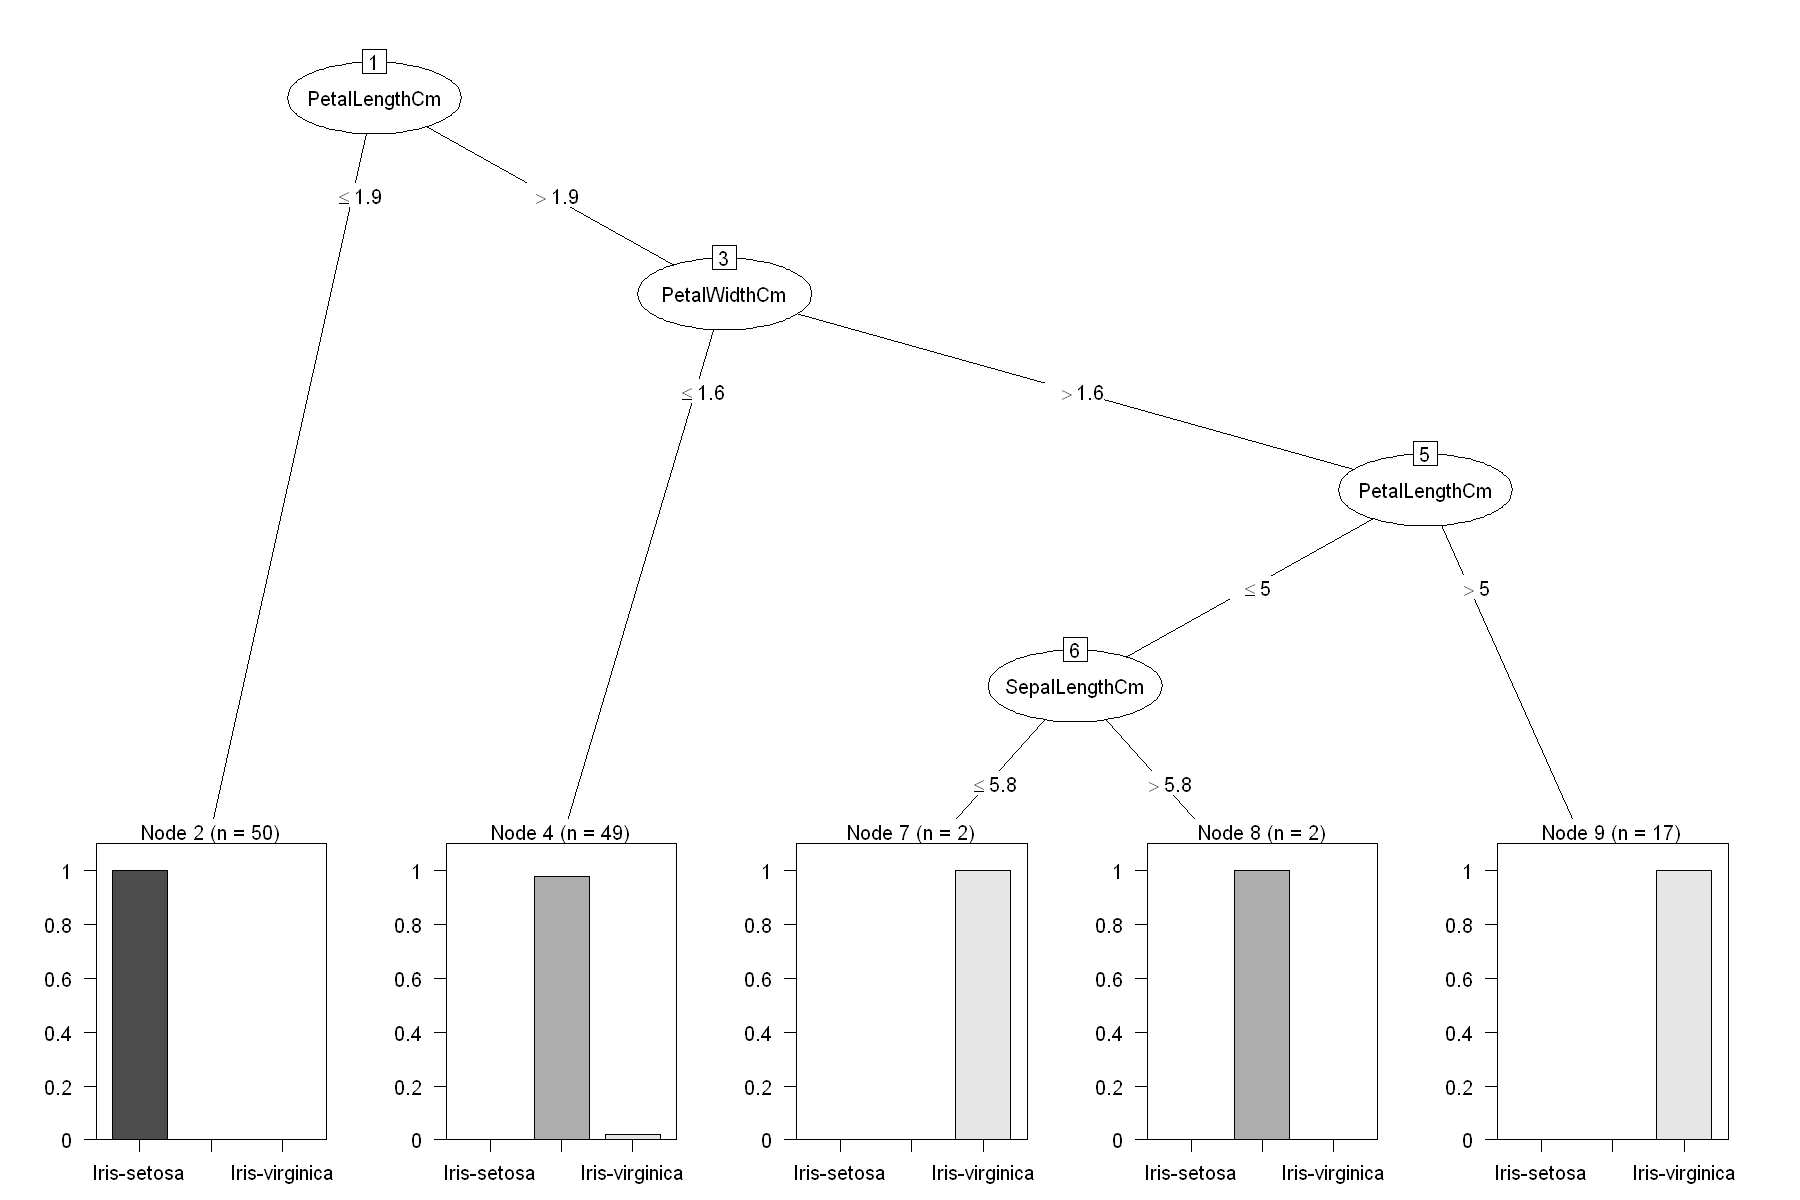

In [30]:
options(repr.plot.width=15, repr.plot.height=10)
in_train <- as.factor(sample(1:nrow(iris_data), size = (0.8*nrow(iris_data))))
train_data <- iris_data[ in_train,]
test_data  <- iris_data[-in_train,]
tree_mod_iris <- C5.0(x = train_data[, 2:5], y = train_data[,6])
plot(tree_mod_iris)
print(paste("Tree size is: ", tree_mod_iris$size))

[1] "Tree size is:  5"


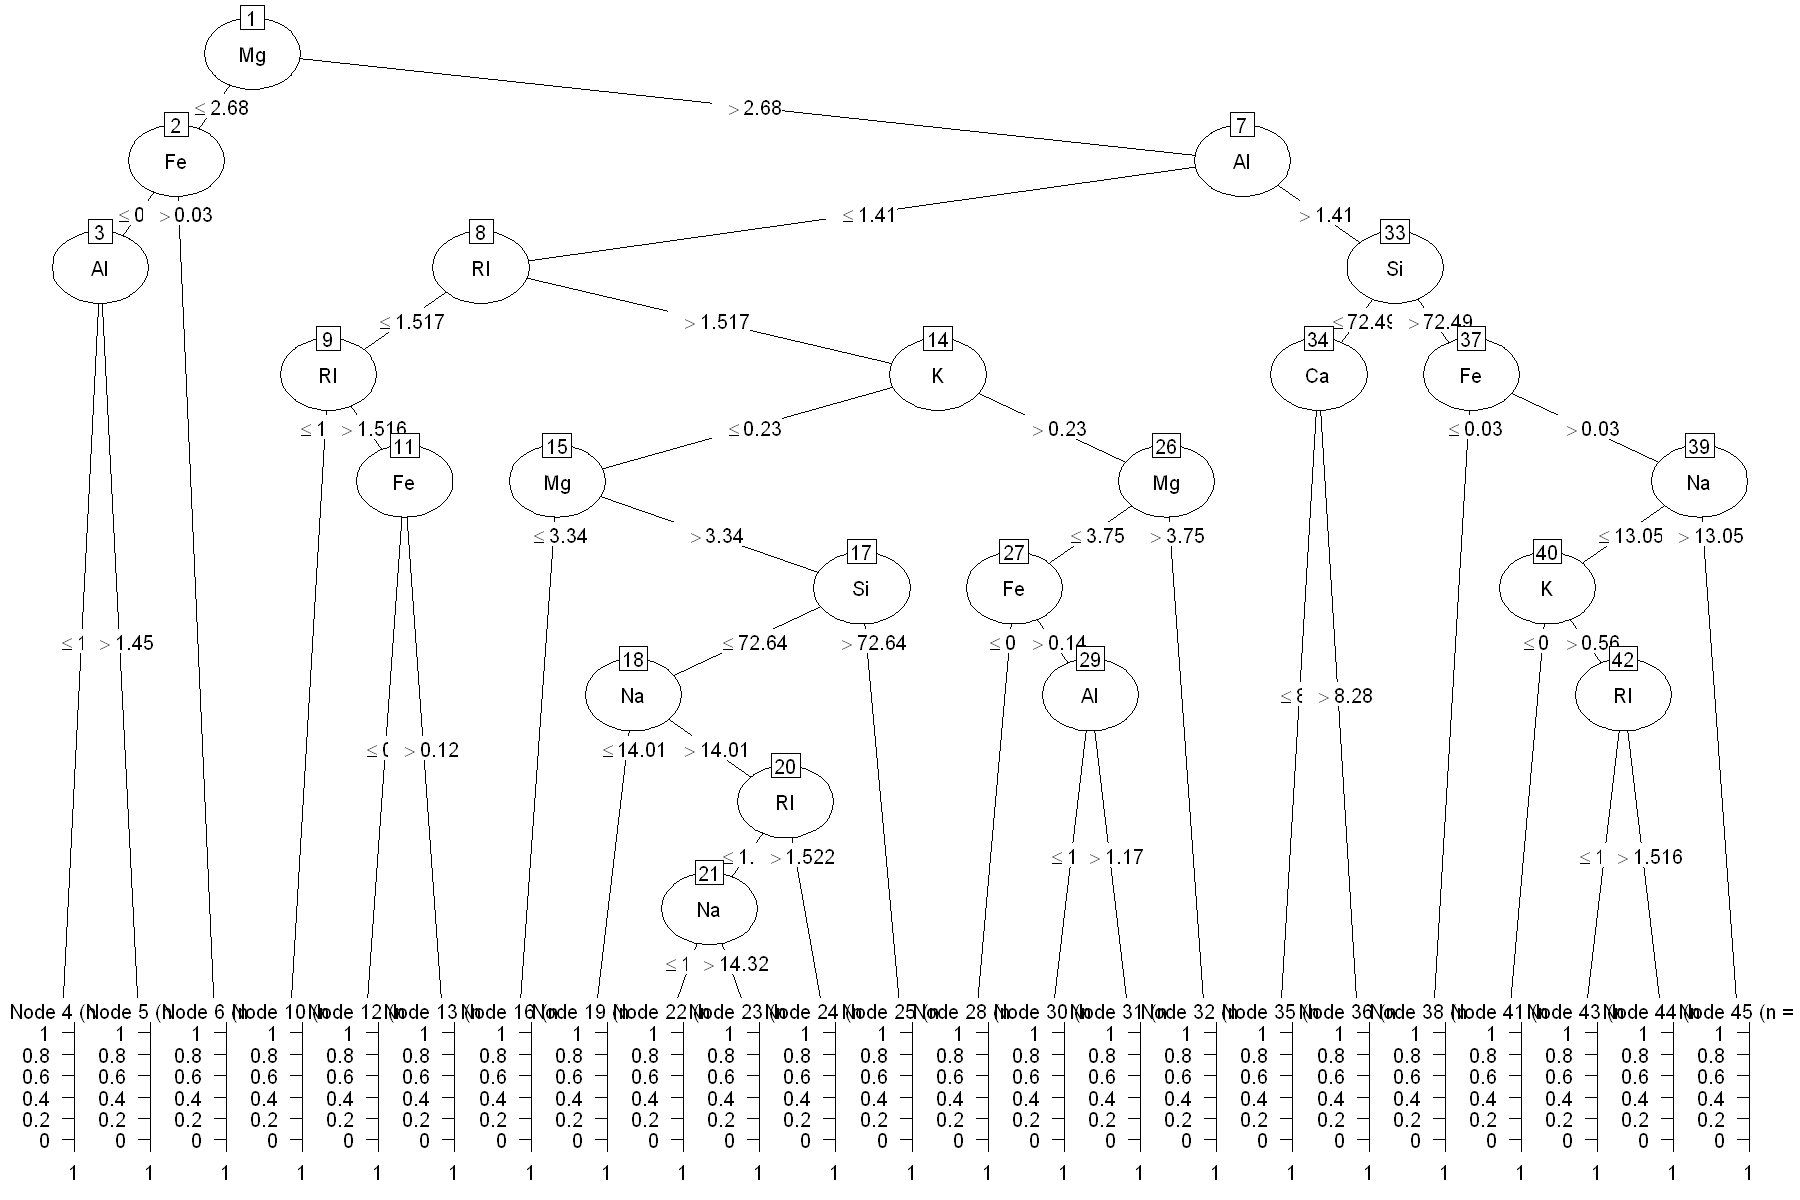

In [31]:
in_train <- as.factor(sample(1:nrow(glass_data), size = (0.8*nrow(glass_data))))
glass_data[,ncol(glass_data)] <- as.factor(glass_data[,ncol(glass_data)])
train_data <- glass_data[ in_train,]
test_data  <- glass_data[-in_train,]
tree_mod_glass <- C5.0(x = train_data[, 1:9], y = train_data[,10])
plot(tree_mod_glass)
print(paste("Tree size is: ", tree_mod_iris$size))

[1] 184


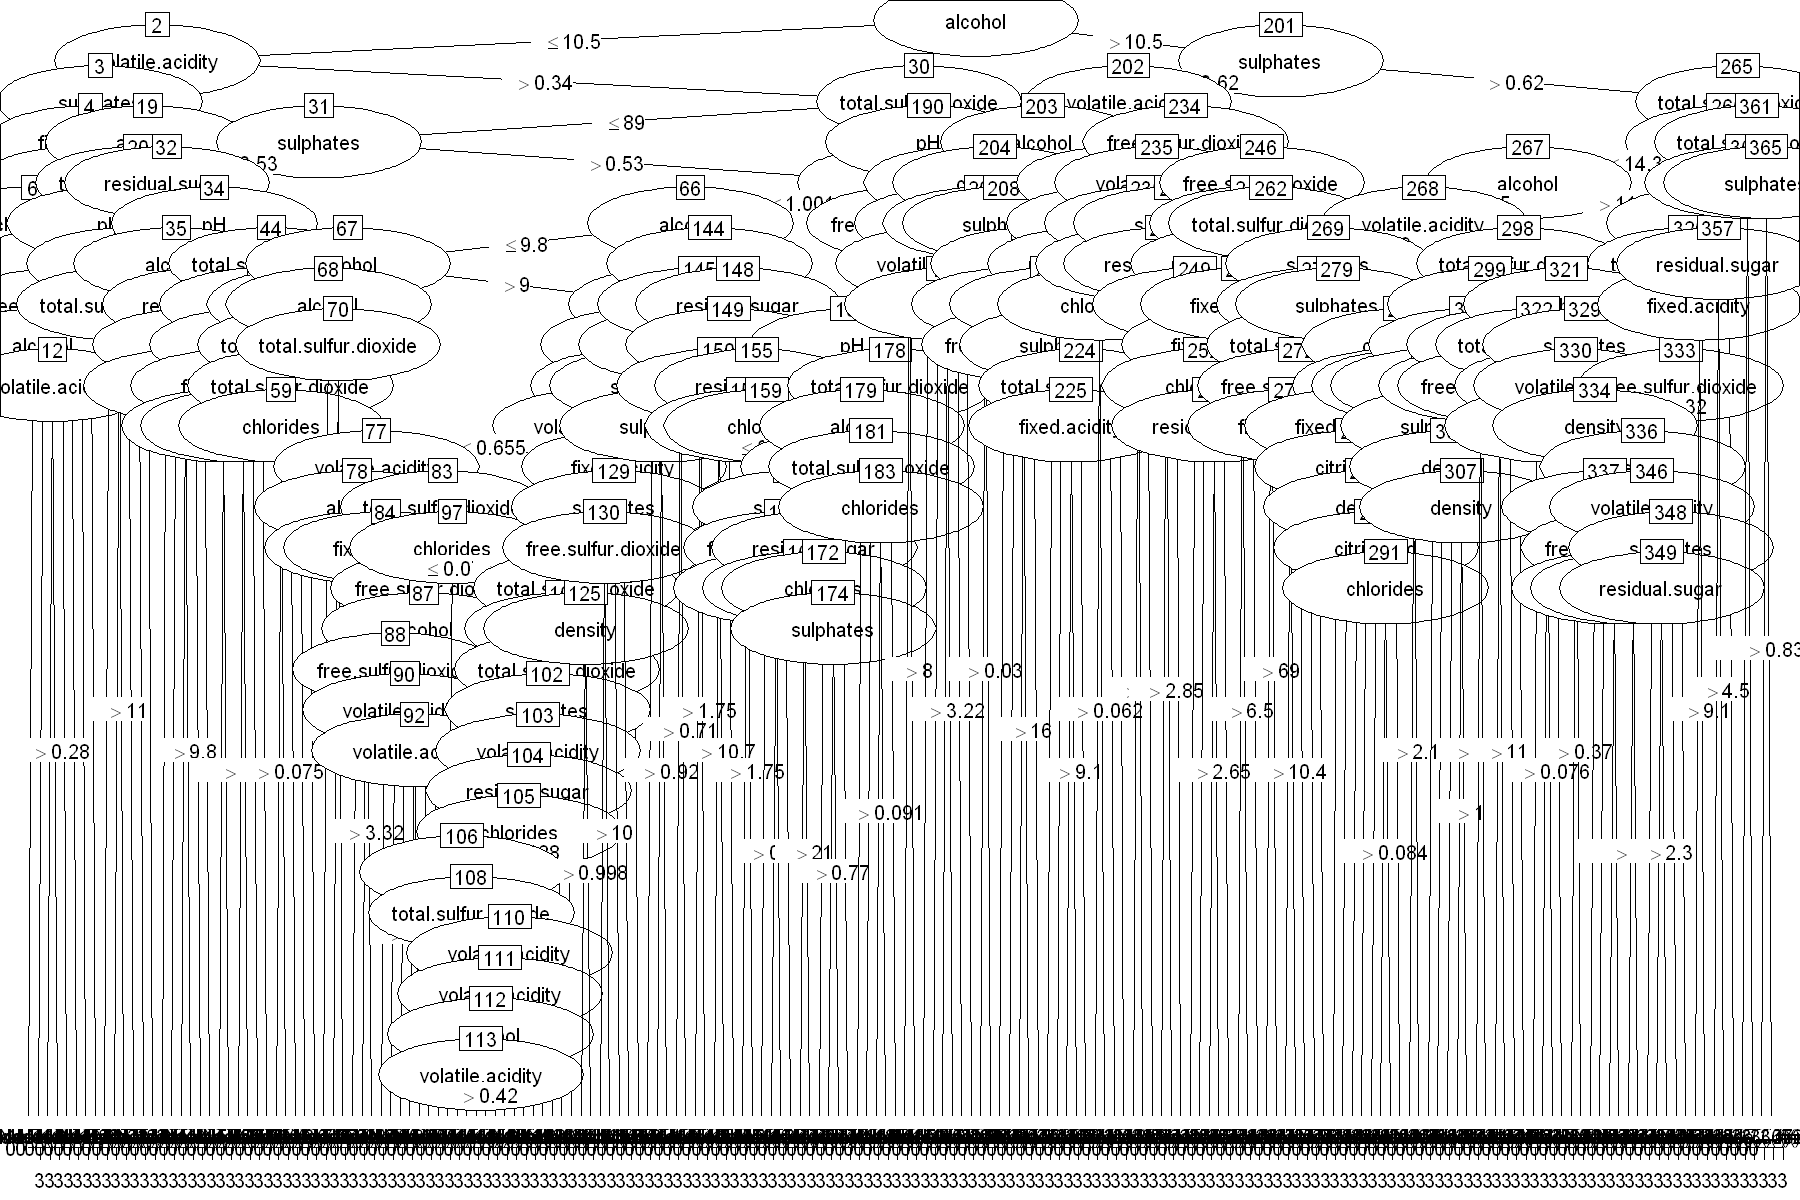

In [26]:
in_train <- as.factor(sample(1:nrow(wine_data), size = (0.8*nrow(wine_data))))
wine_data[,ncol(wine_data)] <- as.factor(wine_data[,ncol(wine_data)])
train_data <- wine_data[ in_train,]
test_data  <- wine_data[-in_train,]
tree_mod_wine <- C5.0(x = train_data[, 1:11], y = train_data[,12])
plot(tree_mod_wine)
print(tree_mod_wine$size)

[1] "Tree size is:  5"


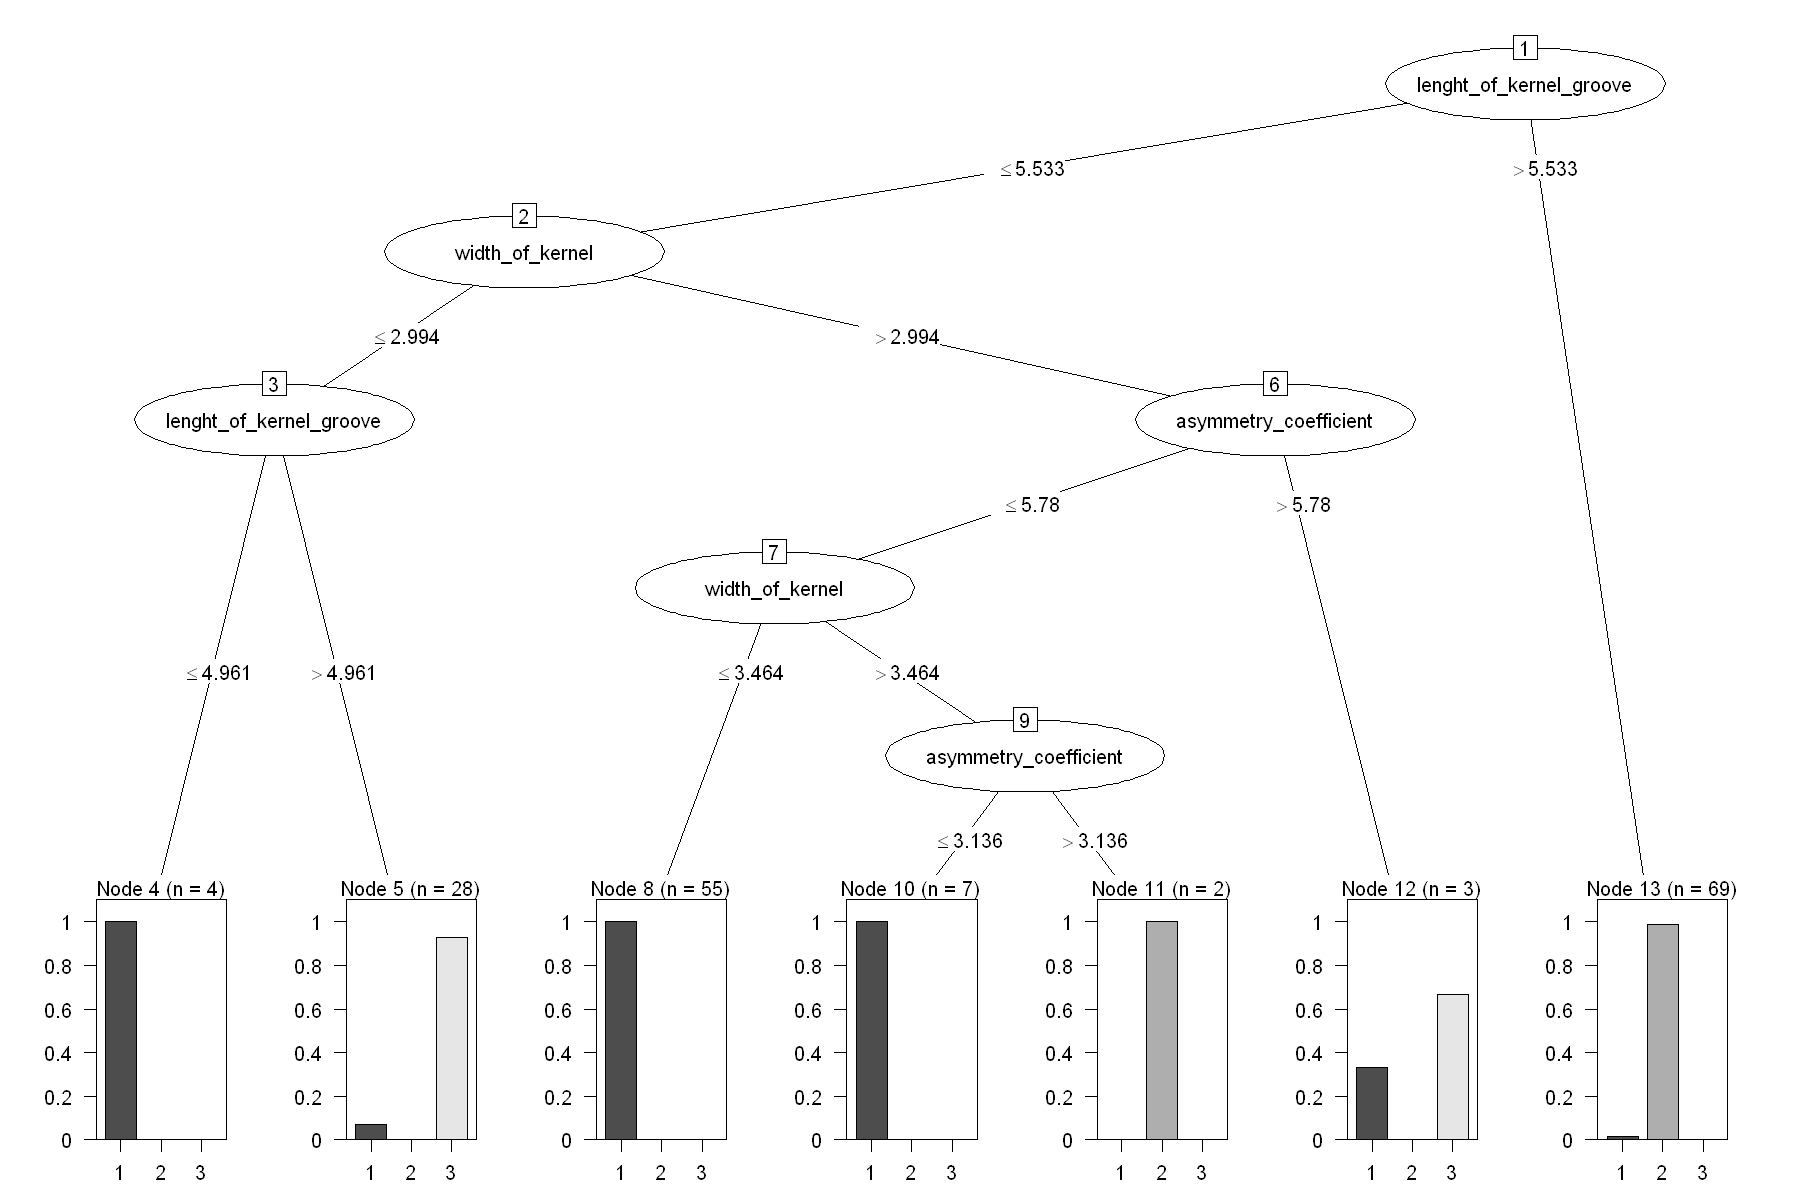

In [40]:
in_train <- as.factor(sample(1:nrow(seed_data), size = (0.8*nrow(seed_data))))
seed_data[,ncol(seed_data)] <- as.factor(seed_data[,ncol(seed_data)])
train_data <- seed_data[ in_train,]
test_data  <- seed_data[-in_train,]
tree_mod_seed <- C5.0(x = train_data[, 1:6], y = train_data[,7])
plot(tree_mod_seed)
print(paste("Tree size is: ", tree_mod_iris$size))

Plan badania:
Dla każdego z foldów (5 , 10 , 15) sprawdzić wartość metryk i każdej kombinacji parametrów (winnow,noGlobalPunning,fuzzyThreshold.


In [41]:
#Sprawdzone parametry dla danego datasetu
research <- function(dataset,start_col,end_col,formula){
    research_dataframe<-data.frame()
    #Params = FALSE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,5,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,5,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #fuzzyThreshold TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,5,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    # pruning TRUE
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,5,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing True & fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,5,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing True & noGlobalPrunning True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,5,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #noGlobalPrunning True fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=F fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,5,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #All params true
    newMeasureDataframe = TreeModel_caret("Tree F=5 winnow=T fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,5,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #FOLDS 10
    #Params False
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,10,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
   
    #Winnowing
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,10,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #fuzzyThredshold
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,10,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Pruning
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,10,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,10,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #Winnowing True & noGlobalPrunning True
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,10,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #noGlobalPrunning True fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=F fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,10,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
   
    #All params true
    newMeasureDataframe = TreeModel_caret("Tree F=10 winnow=T fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,10,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
   
    #Params False
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,15,FALSE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=F  NoPruning=F",dataset,"tree",start_col,end_col,formula,15,TRUE,FALSE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #fuzzyThredshold
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,15,FALSE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Pruning
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,15,FALSE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing True & fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=T  NoPruning=F",dataset,"tree",start_col,end_col,formula,15,TRUE,TRUE,FALSE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    #Winnowing True & noGlobalPrunning True
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=F  NoPruning=T",dataset,"tree",start_col,end_col,formula,15,TRUE,FALSE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
     #noGlobalPrunning True fuzzyThreshold True
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=F fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,15,FALSE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
     #All params true
    newMeasureDataframe = TreeModel_caret("Tree F=15 winnow=T fuzzy=T  NoPruning=T",dataset,"tree",start_col,end_col,formula,15,TRUE,TRUE,TRUE)
    research_dataframe <- rbind(research_dataframe, newMeasureDataframe)
    
    #f1 plot
    library(RColorBrewer)
    coul <- brewer.pal(5, "Set2") 
    par(mar=c(4,19,4,4))
    barplot(height=research_dataframe$f1,
            names=research_dataframe$params,
            col=coul,
            horiz=T,
            width=2,
            las=2,
            xlab="Fscore",)
    return(research_dataframe)
}



[1] "Iris"


params,f1,acc,rec,prec,Tree_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Tree F=5 winnow=F fuzzy=F NoPruning=F,0.9666667,0.9337662,0.9428571,1,4
Tree F=5 winnow=T fuzzy=F NoPruning=F,0.9666667,0.9323377,0.9428571,1,4
Tree F=5 winnow=F fuzzy=T NoPruning=F,0.9692308,0.9151515,0.9428571,1,3
Tree F=5 winnow=F fuzzy=F NoPruning=T,1.0000000,0.9532035,1.0000000,1,4
Tree F=5 winnow=T fuzzy=T NoPruning=F,0.9512821,0.9437229,0.9142857,1,3
Tree F=5 winnow=T fuzzy=F NoPruning=T,1.0000000,0.9519048,1.0000000,1,4
Tree F=5 winnow=F fuzzy=T NoPruning=T,1.0000000,0.9813853,1.0000000,1,3
Tree F=5 winnow=T fuzzy=T NoPruning=T,0.9692308,0.9147186,0.9428571,1,5
Tree F=10 winnow=F fuzzy=F NoPruning=F,0.9657143,0.8936364,0.9416667,1,4


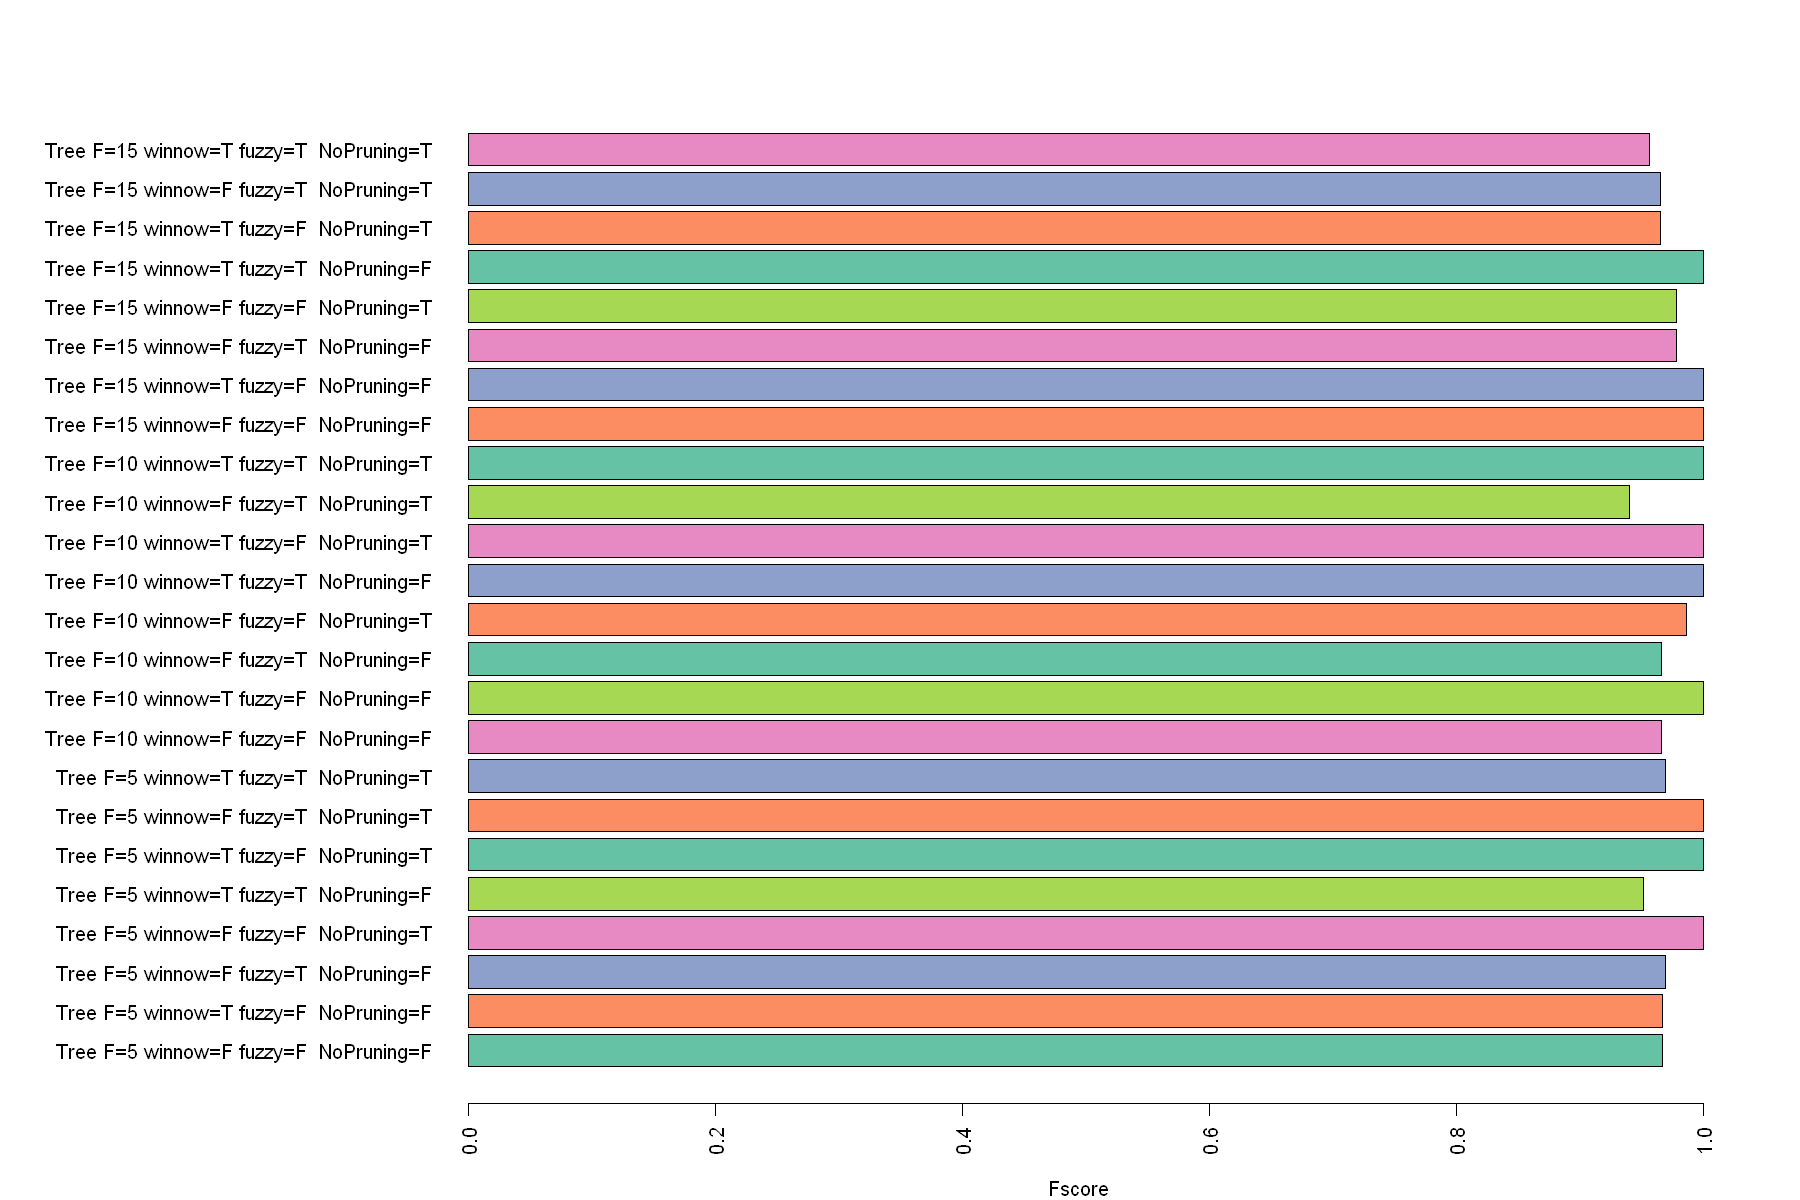

In [42]:
print('Iris')
research(iris_data,2,6,Species~.)

[1] "Seeds"


params,f1,acc,rec,prec,Tree_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Tree F=5 winnow=F fuzzy=F NoPruning=F,0.8952381,0.9328736,0.9333333,0.8651515,6
Tree F=5 winnow=T fuzzy=F NoPruning=F,0.7949673,0.8793103,0.7444444,0.8564286,5
Tree F=5 winnow=F fuzzy=T NoPruning=F,0.8369196,0.8997701,0.8400000,0.8718182,8
Tree F=5 winnow=F fuzzy=F NoPruning=T,0.9089780,0.9323841,0.9272727,0.8974825,6
Tree F=5 winnow=T fuzzy=T NoPruning=F,0.8659954,0.9066667,0.8654545,0.8762393,6
Tree F=5 winnow=T fuzzy=F NoPruning=T,0.8429493,0.8926437,0.8800000,0.8174825,4
Tree F=5 winnow=F fuzzy=T NoPruning=T,0.8099640,0.8793103,0.8133333,0.8194017,6
Tree F=5 winnow=T fuzzy=T NoPruning=T,0.8624030,0.9197405,0.8377778,0.9244444,4
Tree F=10 winnow=F fuzzy=F NoPruning=F,0.8189105,0.8874405,0.8066667,0.8780952,6


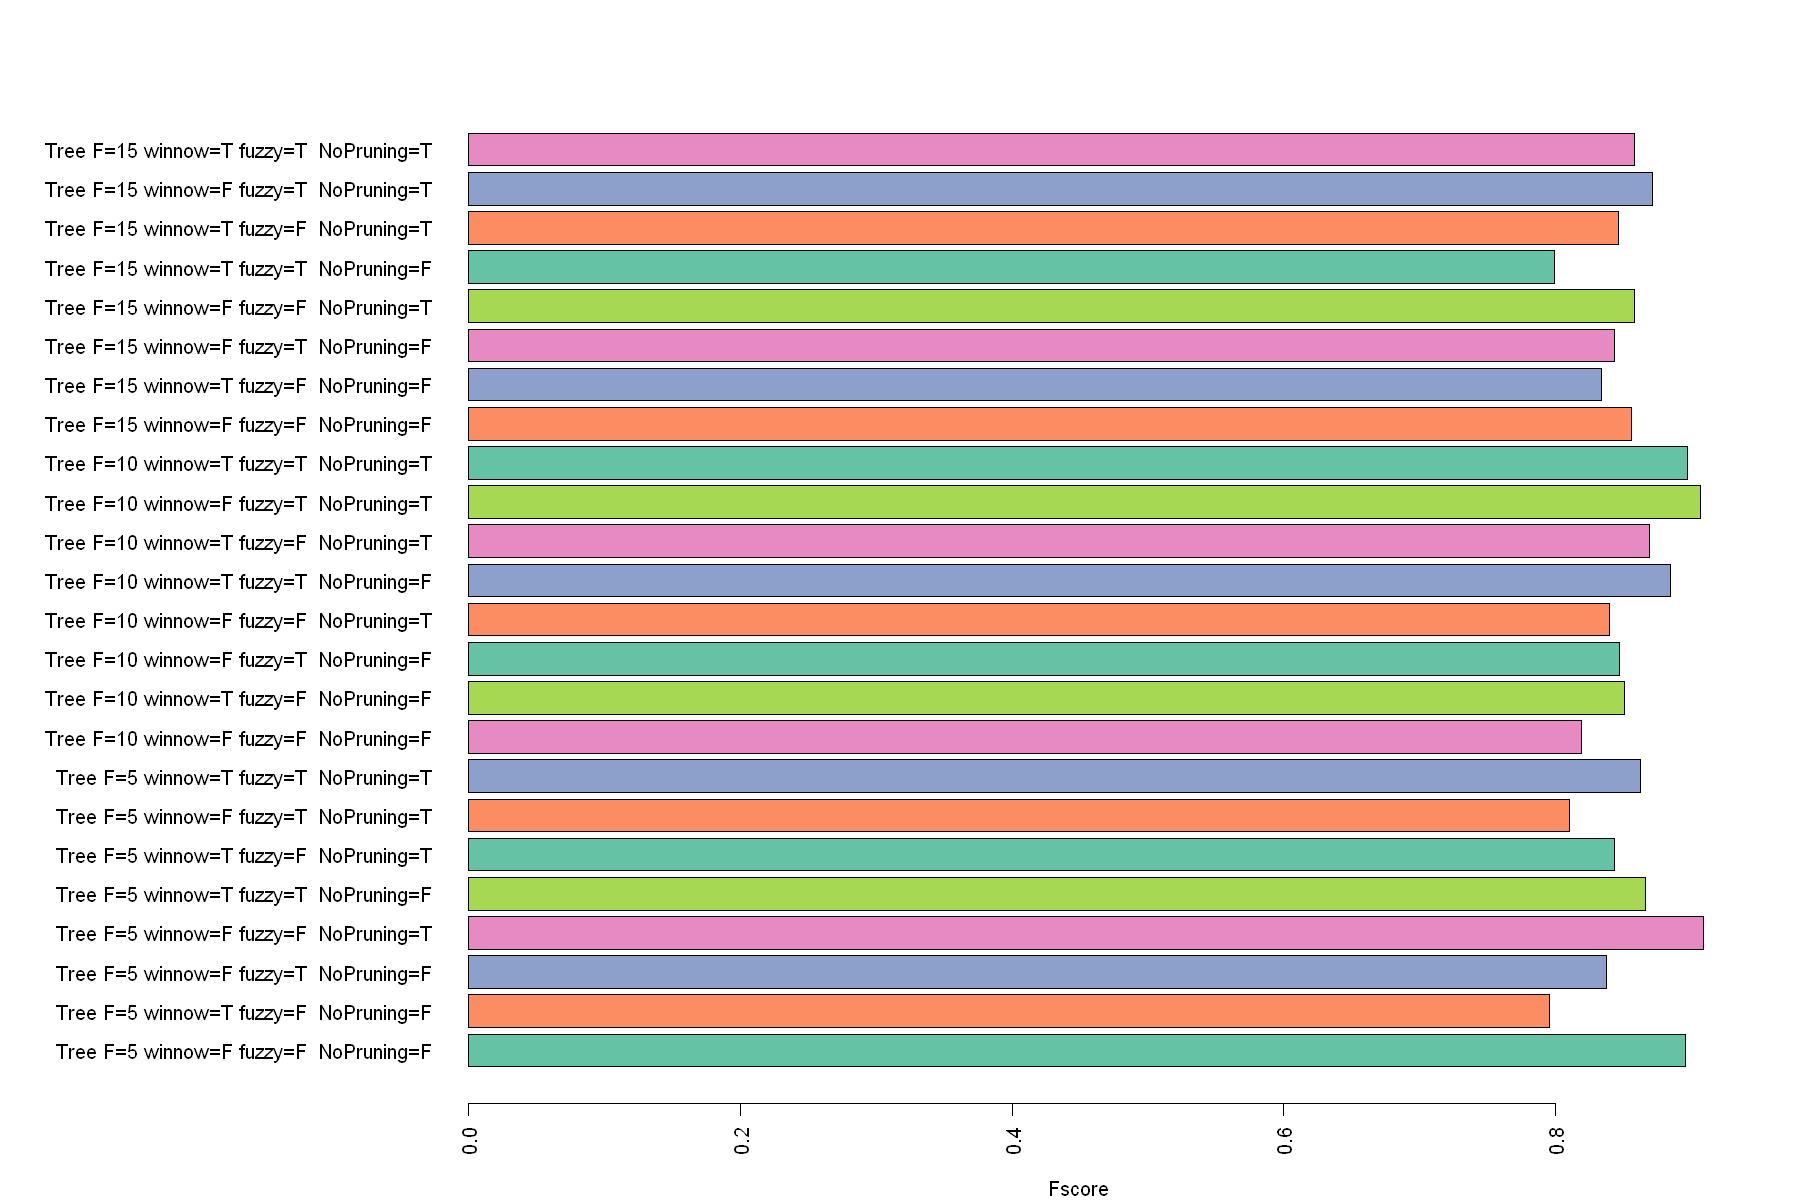

In [43]:
print('Seeds')
research(seed_data,1,7,Type~.)

[1] "Glass"


params,f1,acc,rec,prec,Tree_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Tree F=5 winnow=F fuzzy=F NoPruning=F,0.7056681,0.6732518,0.7111111,0.7142918,16
Tree F=5 winnow=T fuzzy=F NoPruning=F,0.7218382,0.6626279,0.7527273,0.6981818,19
Tree F=5 winnow=F fuzzy=T NoPruning=F,0.7033024,0.6519169,0.7305556,0.6949495,18
Tree F=5 winnow=F fuzzy=F NoPruning=T,0.7254386,0.7196313,0.7333333,0.7247619,17
Tree F=5 winnow=T fuzzy=T NoPruning=F,0.6838923,0.6602966,0.7290909,0.6533333,17
Tree F=5 winnow=T fuzzy=F NoPruning=T,0.6310048,0.6149574,0.6400000,0.6339394,19
Tree F=5 winnow=F fuzzy=T NoPruning=T,0.7305993,0.6472599,0.7000000,0.7806166,24
Tree F=5 winnow=T fuzzy=T NoPruning=T,0.7264861,0.6928725,0.7800000,0.7119048,17
Tree F=10 winnow=F fuzzy=F NoPruning=F,0.7465368,0.6769643,0.7900000,0.7333333,21


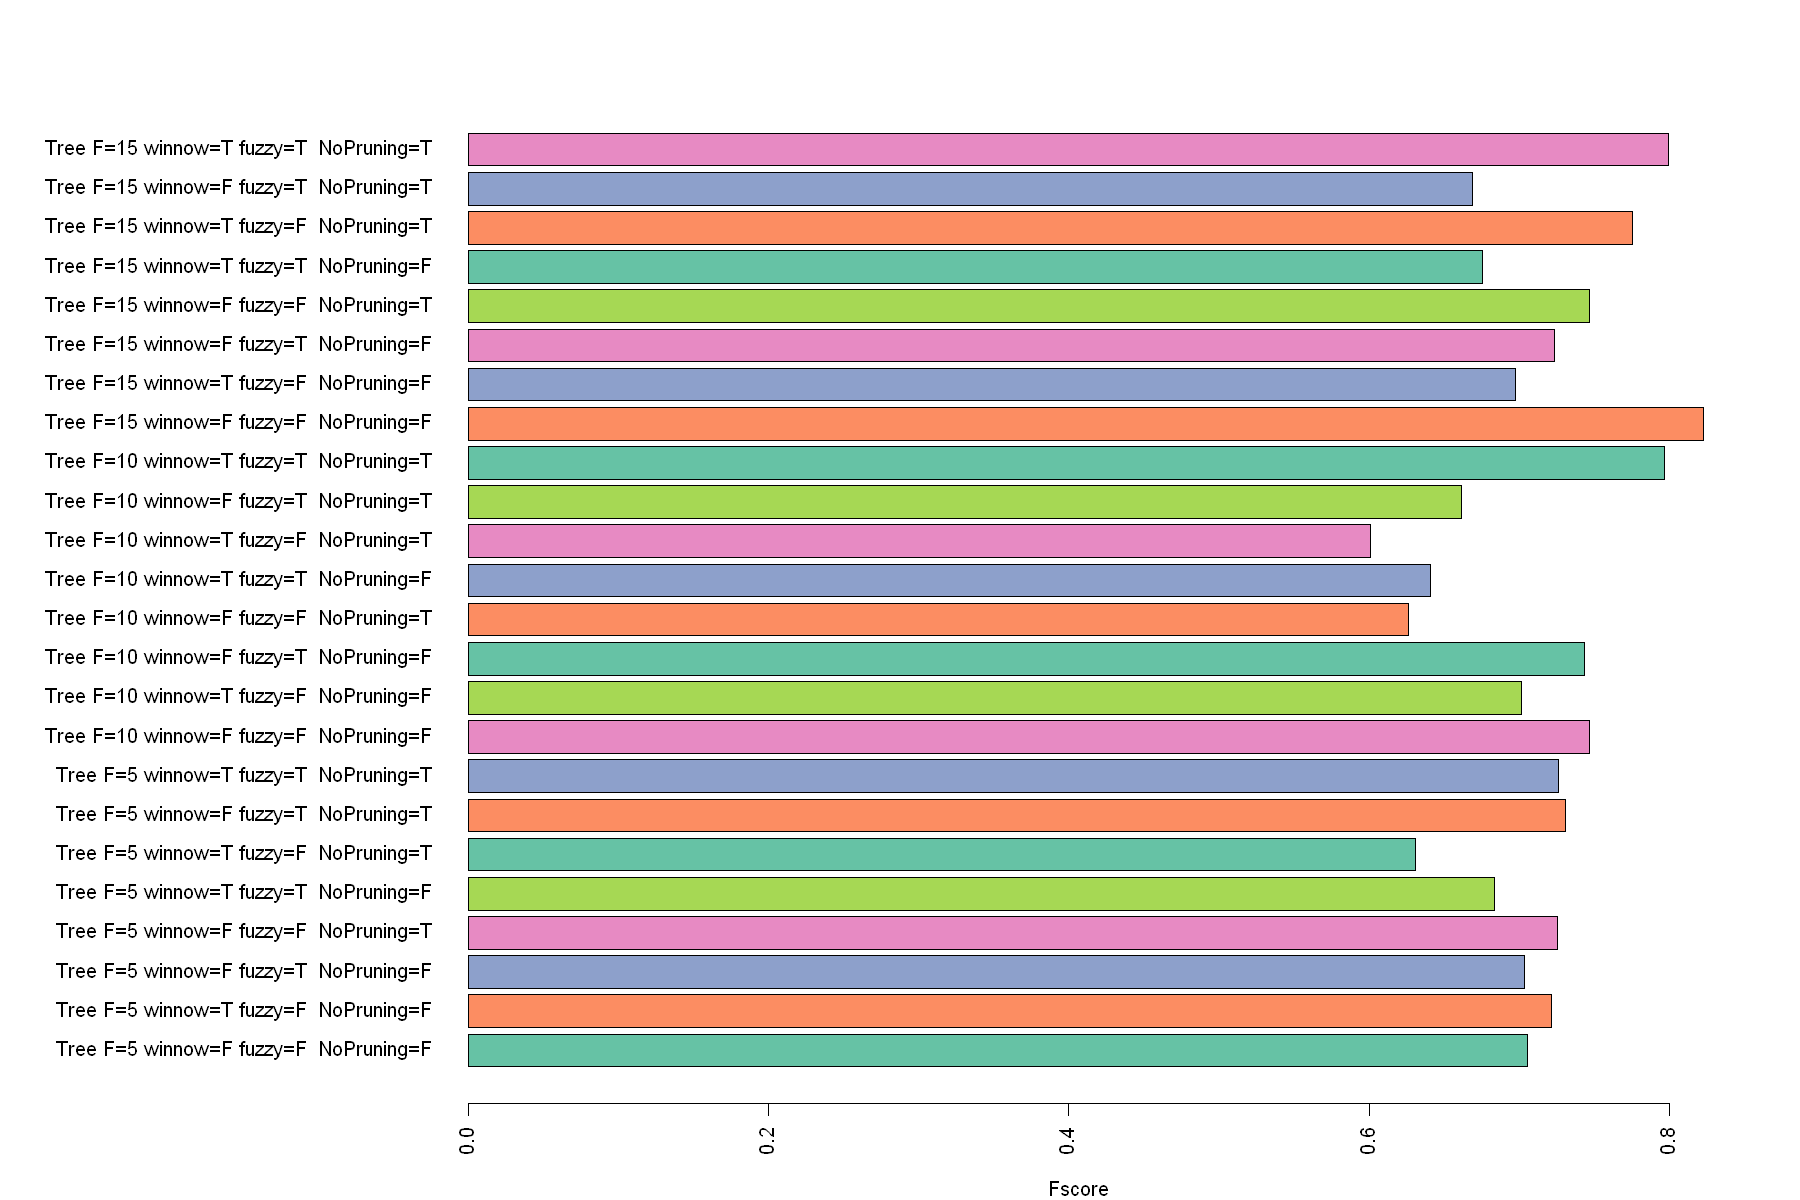

In [44]:
print('Glass')
research(glass_data,1,10,Type~. )

[1] "Wine quality"


params,f1,acc,rec,prec,Tree_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Tree F=5 winnow=F fuzzy=F NoPruning=F,0.5555556,0.5709762,0.3000000,0.45000000,151
Tree F=5 winnow=T fuzzy=F NoPruning=F,0.2500000,0.5869451,0.1000000,0.16666667,141
Tree F=5 winnow=F fuzzy=T NoPruning=F,NaN,0.5932222,0.0000000,NaN,162
Tree F=5 winnow=F fuzzy=F NoPruning=T,NaN,0.5735400,0.0000000,0.00000000,171
Tree F=5 winnow=T fuzzy=T NoPruning=F,NaN,0.5842669,0.0000000,0.00000000,161
Tree F=5 winnow=T fuzzy=F NoPruning=T,NaN,0.5717343,0.0000000,0.00000000,157
Tree F=5 winnow=F fuzzy=T NoPruning=T,0.5833333,0.5977063,0.2000000,0.37500000,140
Tree F=5 winnow=T fuzzy=T NoPruning=T,NaN,0.5637963,0.0000000,0.00000000,145
Tree F=10 winnow=F fuzzy=F NoPruning=F,0.4000000,0.5627651,0.1666667,0.05000000,161


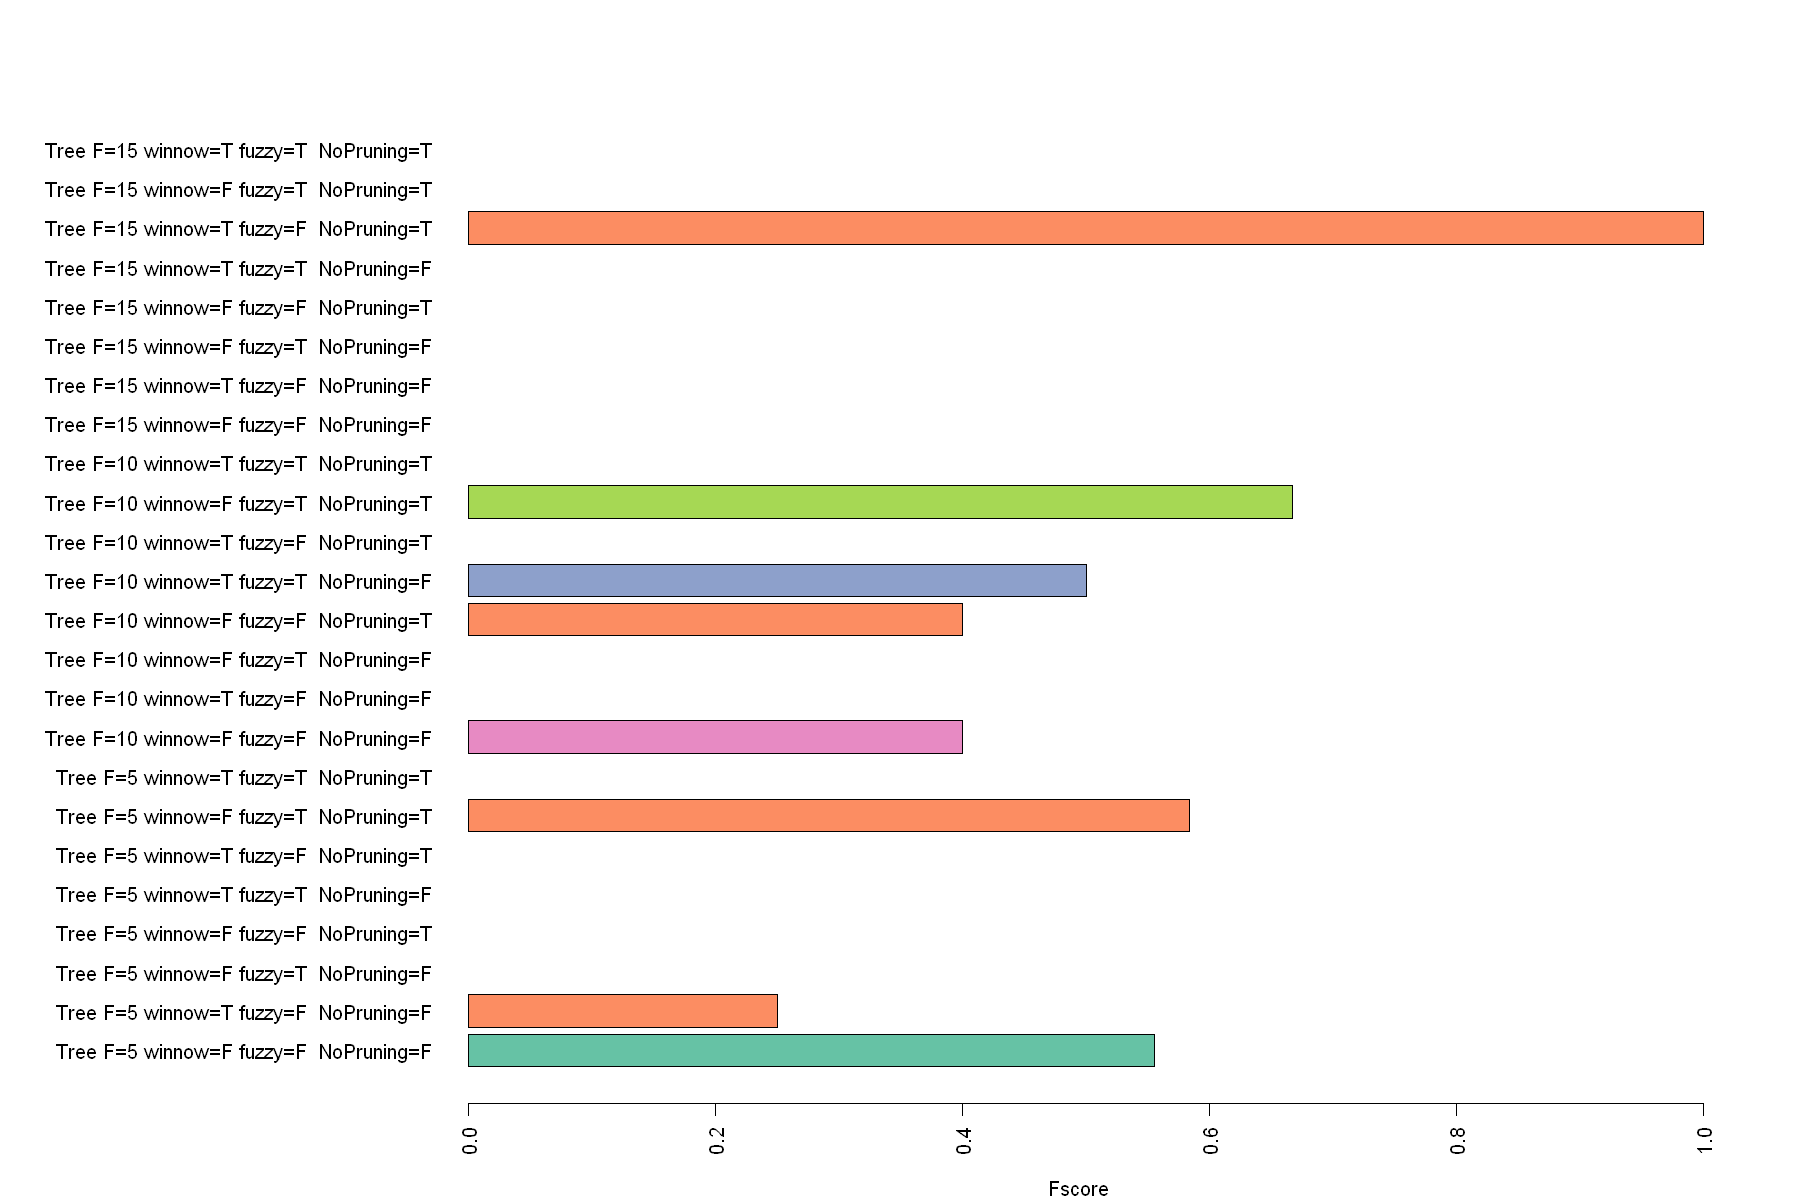

In [45]:
print('Wine quality')
research(wine_data,1,12,quality~.)


Podsumowanie i wnioski:
Badając drzewa decyzyjne dla zbiorów Glass, Seed i Wine można zauważyć że:
- Pomimo posiadania około 60% acc dla zbioru Wine recall posiadał dla wieru testów wartość 0 co powodowało NaN w pozostałych metrykach. Jak widać acc nie jest dobrym wyznacznikiem
- Najlepszymi parametrami dla zbiorów okazały się:\
    -- Seed - Tree F=5 winnow=F fuzzy=F NoPruning=T	0.9089780 \
    -- Glass  - Tree F=15 winnow=T fuzzy=T NoPruning=T	0.7997884 \
    -- Wine  - Tree F=15 winnow=T fuzzy=F NoPruning=T	1.0000000 \
Można zaobserwować że zwiększenie liczby foldów w kroswalidacji miało wpływ na jakość modelu. \
Najmniejszymi drzewami okazały się

    -- Tree F=10 winnow=T fuzzy=T NoPruning=T rozmiar drzewa: 3\
    -- Tree F=15 winnow=T fuzzy=F NoPruning=F rozmiar drzewa: 14\
    -- Tree F=5 winnow=F fuzzy=T NoPruning=T rozmiar drzewa: 140 
    (brałem pod uwagę modele które nie posiadały NaN w metrykach)

Prównując wersje z włączonym parametrem a wyłączonym można zauważyć że winnowing poprzed selekcje atrybutów jak i noGlobalPruning poprzez końcowe obcięcie drzewa ma wpływ na końcową wielkość.

[1] - https://stackoverflow.com/questions/23357855/wrong-model-type-for-regression-error-in-10-fold-cross-validation-for-naive-baye/50317577 \
[2] - https://cran.r-project.org/web/packages/caret/caret.pdf \